In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import re

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

#loading dataset
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP Assignment/train_data.csv")
df_val=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP Assignment/val_data.csv")

print(df_train.head())
print(df_val.head())

                                               input  labels
0    I am reading score of Mahler is Symphony No . .       0
1  I am not interested in cars or electric applia...       1
2         This is my homework for my English class .       0
3  In comparison , Canada is catches increased an...       0
4  Fortunately , my older sister is friend is a d...       1
                                               input  labels
0                            It was the same thing .       0
1                          I can study idioms a lot        1
2      I just bet some coins for numbers or colors .       0
3  Yesterday , I was checking some e - mails on b...       1
4  I regret that I have not played the piano very...       1


In [5]:
#Checking for Null Entries
print(df_train.info())
print(df_val.info())


# Number of positive and negative labels
print(df_train.labels.value_counts())
print(df_val.labels.value_counts())


# Get the lists of labels.
labels_train = df_train.labels.values
labels_val = df_val.labels.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   19998 non-null  object
 1   labels  19998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   10000 non-null  object
 1   labels  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None
0    9999
1    9999
Name: labels, dtype: int64
0    5000
1    5000
Name: labels, dtype: int64


In [6]:
'''THIS FUNCTION REMOVES THE SPACES BETWEEN THE CONTRACTED WORDS AND REMOVING UNNECESSARY SPACES IN THE SENTENCES
            ca n't ==> can't 
            I 'm ===> I'm ...etc
'''
def remove_spaces(text):
    text = re.sub(r" '(\w)",r"'\1",text)
    text = re.sub(r" \,",",",text)
    text = re.sub(r" \.+",".",text)
    text = re.sub(r" \!+","!",text)
    text = re.sub(r" \?+","?",text)
    text = re.sub(" n't","n't",text)
    text = re.sub("[\(\)\;\_\^\`\/]","",text)
    
    return text


'''THIS FUNCTION DECONTRACTS THE CONTRACTED WORDS'''

def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


'''THIS FUNCTION PREPROCESSES THE TEXT '''
def preprocess(text):
    text = remove_spaces(text)   # REMOVING UNWANTED SPACES
    text = decontract(text)    # DECONTRACTION
    text = text.lower() ## CONVERTING TO LOWER CASE
    return text ## RETURNING THE PROCESSED TEXT

In [7]:
sentences_train=[]
for sentence in df_train.input:
  sentence = preprocess(sentence)
  sentences_train.append(sentence)


sentences_val=[]
for sentence in df_val.input:
  sentence = preprocess(sentence)
  sentences_val.append(sentence)

1911
52.75247524752475


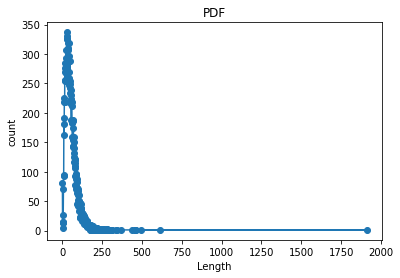

In [8]:
length=[]
for i in range(len(sentences_train)):
    l=len(sentences_train[i])
    length.append(l)
print(max(length))
print(sum(length) / len(length))

x=set(length)
y=[]
for i in x:
  y.append(length.count(i))

x=list(x)
# plotting
plt.xlabel('Length')
plt.ylabel('count')
plt.title('PDF')
plt.plot(x, y, marker='o')

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [10]:
# Process of tokenization
print(' Original: ', sentences_train[0])
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  i am reading score of mahler is symphony no..
Tokenized:  ['i', 'am', 'reading', 'score', 'of', 'ma', '##hler', 'is', 'symphony', 'no', '.', '.']
Token IDs:  [1045, 2572, 3752, 3556, 1997, 5003, 13620, 2003, 6189, 2053, 1012, 1012]


In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs for training.
input_ids_train = []
attention_masks_train = []

for sentence in sentences_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sentence,                      
                        add_special_tokens = True, 
                        max_length = 350,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
    
    # Adding encoding of sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Converting into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sample sentence 
print('Original: ', sentences_train[0])
print('Token IDs:', input_ids_train[0])
print('Token attention_masks: ', attention_masks_train[0])


# Tokenize all of the sentences and map the tokens to thier word IDs for validation.
input_ids_val = []
attention_masks_val = []

for sentence in sentences_val:

    encoded_dict = tokenizer.encode_plus(
                        sentence,                      
                        add_special_tokens = True, 
                        max_length = 350,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
    
    input_ids_val.append(encoded_dict['input_ids'])
    
    attention_masks_val.append(encoded_dict['attention_mask'])

input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  i am reading score of mahler is symphony no..
Token IDs: tensor([  101,  1045,  2572,  3752,  3556,  1997,  5003, 13620,  2003,  6189,
         2053,  1012,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,    

In [12]:
from torch.utils.data import TensorDataset

# Combine the training and validation inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# batch size of 16 or 32 (the authors recommend). 
batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# To run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [16]:
# AdamW is a class from the huggingface library 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# But for this task model starts to overfit after epoch 1 so we keep it as 1
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 123

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

print('Training............................')

# For each epoch...
for epoch_i in range(0, epochs):
    
    #Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        loss = outputs.loss
        total_train_loss += loss

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.(This is to help prevent the "exploding gradients" problem.)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        

    # measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation model 
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is validation (not training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Training............................

======== Epoch 1 / 1 ========
  Batch    50  of    625.    Elapsed: 0:01:26.
  Batch   100  of    625.    Elapsed: 0:02:56.
  Batch   150  of    625.    Elapsed: 0:04:27.
  Batch   200  of    625.    Elapsed: 0:05:58.
  Batch   250  of    625.    Elapsed: 0:07:29.
  Batch   300  of    625.    Elapsed: 0:09:00.
  Batch   350  of    625.    Elapsed: 0:10:31.
  Batch   400  of    625.    Elapsed: 0:12:02.
  Batch   450  of    625.    Elapsed: 0:13:33.
  Batch   500  of    625.    Elapsed: 0:15:05.
  Batch   550  of    625.    Elapsed: 0:16:36.
  Batch   600  of    625.    Elapsed: 0:18:07.

  Average training loss: 0.66
  Training epcoh took: 0:18:52

Running Validation...
  Accuracy: 0.61
  Validation Loss: 0.64
  Validation took: 0:03:49

Training complete!
Total training took 0:22:41 (h:mm:ss)


In [21]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,"tensor(0.6563, device='cuda:0', grad_fn=<DivBa...",0.64,0.61,0:18:52,0:03:49


# Validation

In [22]:
validation_dataloader = DataLoader(
        val_dataset, # The validation samples.
        sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
        batch_size = 1 # Evaluate with this batch size.
    )

logits_arr=[]
label_ids_arr=[]

model.eval()

for batch in validation_dataloader:

  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is validation (not training)
  with torch.no_grad():        

      # Forward pass, calculate logit predictions.
      # The "logits" are the output
      # values prior to applying an activation function like the softmax.
      outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask
                      )
      
  # Accumulate the validation loss.
  loss = outputs.loss
  logits = outputs.logits

  # Move logits and labels to CPU
  logits_arr.append(logits.detach().cpu().numpy())
  label_ids_arr.append(b_labels.to('cpu').numpy())

In [23]:
# Creating lists of prediction and true label
pred_labels=[]
labels=[]
for i in range(len(logits_arr)):
  pred_labels.append(np.argmax(logits_arr[i], axis=1)[0])
  labels.append(label_ids_arr[i][0])

In [24]:
# Metrics Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

cm = confusion_matrix(labels, pred_labels)
print(cm)
print("accuracy_score: ",accuracy_score(labels, pred_labels))
print("precision_score: ",precision_score(labels, pred_labels))
print("recall_score: ",recall_score(labels, pred_labels))
print("f1_score: ",f1_score(labels, pred_labels))

[[1629 3371]
 [ 544 4456]]
accuracy_score:  0.6085
precision_score:  0.5693113581193305
recall_score:  0.8912
f1_score:  0.6947844390738287


In [36]:
# Analysis of tokens
sentence = "There are many laptopps around!"
print(' Original: ', sentence)
print('Tokenized: ', tokenizer.tokenize(sentence))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

 Original:  There are many laptopps around!
Tokenized:  ['there', 'are', 'many', 'laptop', '##ps', 'around', '!']
Token IDs:  [2045, 2024, 2116, 12191, 4523, 2105, 999]


#Testing

In [26]:
df_test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP Assignment/test_data.csv")

#Checking for Null Entries
print(df_test.info())


sentences_test=[]
for sentence in df_test.input:
  sentence = preprocess(sentence)
  sentences_test.append(sentence)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9972 entries, 0 to 9971
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   9972 non-null   object
dtypes: object(1)
memory usage: 78.0+ KB
None


In [27]:
# Tokenize all of the sentences and map the tokens to thier word IDs for training.
input_ids_test = []
attention_masks_test = []

for sentence in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sentence,                      
                        add_special_tokens = True, 
                        max_length = 350,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
    
    # Adding encoding of sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Converting into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

# Print sample sentence 
print('Original: ', sentences_test[0])
print('Token IDs:', input_ids_test[0])
print('Token attention_masks: ', attention_masks_test[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  i believe they will master japanese soon because they were selected as scholarship recipients.
Token IDs: tensor([  101,  1045,  2903,  2027,  2097,  3040,  2887,  2574,  2138,  2027,
         2020,  3479,  2004,  6566, 15991,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [28]:
# Combine the training and validation inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

test_dataloader = DataLoader(
        test_dataset, # The validation samples.
        sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
        batch_size = 1 # Evaluate with this batch size.
    )

logits_arr=[]
label_ids_arr=[]

model.eval()

for batch in test_dataloader:

  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)

  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is validation (not training)
  with torch.no_grad():        

      # Forward pass, calculate logit predictions.
      # The "logits" are the output
      # values prior to applying an activation function like the softmax.
      outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask
                      )
      
  # Accumulate the validation loss.
  loss = outputs.loss
  logits = outputs.logits

  # Move logits and labels to CPU
  logits_arr.append(logits.detach().cpu().numpy())

In [29]:
# Creating lists of prediction and true label
test_labels=[]
for i in range(len(logits_arr)):
  test_labels.append(np.argmax(logits_arr[i], axis=1)[0])

In [30]:
df_test['labels'] = test_labels
df_test.head()

,input,labels
0,I believe they will master Japanese soon becau...,1
1,I am looking for it .,1
2,Apple is a round fruit with smooth and colorfu...,1
3,Let It Will Be Push .,0
4,I rode on this ship from Sendai .,1


In [31]:
df_test.to_csv("shivshankar_shukla_submission.csv")